#Qn4
*Code takes 1-2 mins to run in free google colab*

I struggled to understand BlackJAX which was also found to not be available by default in the google colab IDE. Hence I have not used blackjax and all random samplings were done through JAX alone.

All randomness is based on the variable 'master_key'. Hence change 'master_key' to change output. 

Importing jax and matplotlib

In [164]:
import jax
import matplotlib.pyplot as plt

# Randomness for the entire program
master_key=7 # Decides the output change d
key = jax.random.PRNGKey(master_key)
subkey, key = jax.random.split(key)

#Generation of data points
  The generation is as follows,
*   The variable 'instances' tells the number of data_point instances
*   Input data_points(X) are sampled uniformly in the interval $\in\ $\[lower_limit , upper_limit]
*   Noise(N) are gaussian samples with mean=0 and variance=Noise_var
*   Given X, N the output data_points(Y) is generated as $Y=X*True\_slope+True\_bias+N$
*   The variables 'True_slope', 'True_bias' are initialized by default as True_slope=0.5, True_bias=0.5



In [165]:
instances=30; # Number of data_point instances 

# The data_point samples are declared global
global X, Y, Noise_var

# Limits of the input data_pints
Lower_limit=0; 
Upper_limit=1;

True_bias=1
True_slope=1
Noise_var=0.02

# The input data_points are sampled uniformly in the interval specified by the limits
X=jax.random.uniform(subkey, [instances], minval=Lower_limit, maxval=Upper_limit)
subkey, key = jax.random.split(key)

# Noise, 'N' is generated
N=jax.numpy.sqrt(Noise_var) * jax.random.normal(subkey, [instances])
subkey, key = jax.random.split(key)

# Output data_points are generated as described in the text above.
Y = True_slope*X  +True_bias + N

#Defining Posterior probability
Based on our generation of data points, the likelihood $\mathcal{L}(Y|X,True\_slope,True\_bias)=\mathcal{N}(0,Noise\_var)$

We shall assume a non-informative uniform prior for both $True\_slope, True\_bias$ that allows all values in $(-\infty,\infty)$

Note that with such a prior, the posterior becomes proportional to the likelihood. Hence to posterior probabilities can be obtained in a proportional manner by computing the likelihoods

The function 'posterior()' below returns a value proportional to the posterior probability by computing the likelihood. It takes the parameter values for which the posterior is found as arguments('Est_bias' and 'Est_slope')

In [166]:
def posterior(Est_bias, Est_slope):
  # Data_points and Noise variance to be read
  global X, Y, Noise_var

  # The likelihood and hence the posterior are computed in a 'proportional' manner here.
  # The value returned is the exponential of the sum squared distances
  sum=0
  for i in range(jax.numpy.size(X)):
    sum = sum-((Y[i]-X[i]*Est_slope-Est_bias) * (Y[i]-X[i]*Est_slope-Est_bias)/(2*Noise_var))
  return jax.numpy.exp(sum)

#Plotting the posterior distribution
We shall plot the posterior distribution. To do this, The posterior distribution is sampled at uniform intervals of parameter values by the code below. The variable 'No_of_posterior_points' tells the number of samples of the posterior PDF along each parameter axis.

(Do note that the posterior probability values obtained are not the exact values but 'proportional' ones that are scaled by some factor. But they would suffice for plotting)

We also find the parameter values that correspond to the highest posterior(Bias_prediction, Slope_prediction). Since the posterior is directly proportional to the likelihood in our case, the same parameter values also maximise the likelihood. Hence those parameter values are the Maximum likelihood solutions and the same as the linear regression solutions.

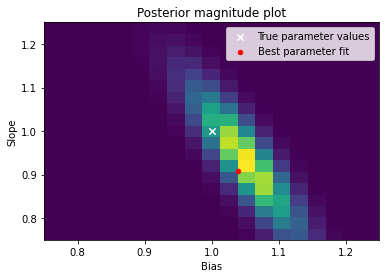

In [167]:
# Number of samples of the posterior along each parameter axis
No_of_posterior_points=20

# Parameter limits of the posterior distribution plot
lower_limit=0.75
upper_limit=1.25

# This variable stores the posterior values at the sample positions
Posterior_values = jax.numpy.zeros([No_of_posterior_points, No_of_posterior_points])
# This variable stores the bias values at the sample positions
Bias_points = jax.numpy.zeros([No_of_posterior_points, No_of_posterior_points])
# This variable stores the slope values at the sample positions
Slope_points = jax.numpy.zeros([No_of_posterior_points, No_of_posterior_points])

# SAMPLING THE POSTERIOR HERE
Current_posterior_max=-1
for i in range(No_of_posterior_points): # This loop changes bias values
  for j in range(No_of_posterior_points): # This loop changes slope values

    Bias_points = Bias_points.at[i,j].set(lower_limit + (upper_limit-lower_limit)*i/(No_of_posterior_points-1) )
    Slope_points = Slope_points.at[i,j].set(lower_limit + (upper_limit-lower_limit)*j/(No_of_posterior_points-1) )    
    Posterior_values = Posterior_values.at[i,j].set(posterior(Bias_points[i,j], Slope_points[i,j]))

    # Find the highest posterior value and the corresponding parameter values
    if(Posterior_values[i,j] > Current_posterior_max):
      Current_posterior_max = Posterior_values[i,j]
      Bias_prediction = Bias_points[i,j]
      Slope_prediction = Slope_points[i,j]

# Plotting the sampled posterior here as a color map
fig, ax = plt.subplots()
ax.pcolormesh(Bias_points, Slope_points, Posterior_values)
ax.scatter(True_bias, True_slope, s=40, c='white', marker='x', label='True parameter values')
ax.scatter(Bias_prediction, Slope_prediction, s=20, c='red', label='Best parameter fit')
plt.title("Posterior magnitude plot")
plt.xlabel("Bias")
plt.ylabel("Slope")
plt.legend();

Notice how the posterior signifies that when bias decreases after the mean, slope must increase and vice-verse for a good fit. This makes sense as this ensures that the linear fit always crosses the mean of the data_points.

#Finding Posterior CDF from the sampled posterior PDF
Here we obtain the CDF of the posterior from the sampled approximate version of posterior PDF(Posterior_values). We do this because we shall sample the posterior later and sampling through the CDF is easier than sampling through the PDF. 

Our CDF is not a traditional CDF but a CDF defined as such, $$CDF(bias_{i},slope_{j})=\sum_{k=1}^{k=i-1}\sum_{l}PDF(bias_{k},slope_{l})+\sum_{l=1}^{l=j}PDF(bias_{i},slope_{l})$$

Note that our posterior PDF and CDF are both histogramic versions of their true counterparts due to sampling.

In [168]:
# Normalizing the posterior PDF
Posterior_values = Posterior_values/jax.numpy.sum(Posterior_values)

# Initializing the posterior CDF
Posterior_CDF = jax.numpy.zeros([No_of_posterior_points,No_of_posterior_points])

# Creating the approximate posterior CDF from the sampled PDF
sum=0
for i in range(No_of_posterior_points):
  for j in range(No_of_posterior_points):
    sum = sum+Posterior_values[i,j];
    Posterior_CDF = Posterior_CDF.at[i,j].set(sum)

#Sampling posterior
Here we sample the posterior distribution for parameter values. The sampling is done as follow,


*   Create samples of a uniform random variable
*   Map the unifrom random variable samples through our approximate, sampled versions of posterior CDF.

The sampling process is just the CDF mapping that converts uniform random variable samples to samples of the posterior distribution

The given problem was to plot 2 standard deviations around the predictive mean. This requires finding the standard deviation from the posterior distribution which is complicated. 

Hence this was not done but rather, we sample the posterior 18 times and then plots those samples. The spread of those posterior samples around the predictive mean will give a general idea of 2 standard devations around the mean. Note that '18' was chosen because 2 standard deviation corresponds to 95% probability and $0.95^{18}\approx0.4$, which implies that with probability $0.6$ atleast one of of samples will cross the 2 std mark. Hence 18 samples was found to be 'good-enough' to show 2 standard deviations.

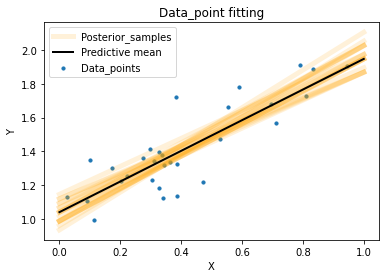

In [169]:
No_of_parameter_samples=18; # Number of posterior samples
plot_points=jax.numpy.linspace(Lower_limit, Upper_limit, 100) # Plotting points range
fig, ax = plt.subplots()

for instance in range(No_of_parameter_samples):
  # Sampling the uniform random variable
  CDF_value = jax.random.uniform(subkey, [1], minval=0, maxval=1)
  subkey, key = jax.random.split(key)

  # Converting the uniform random variable samples to posterior samples
  found=0
  for i in range(No_of_posterior_points):
    for j in range(No_of_posterior_points):
      if(Posterior_CDF[i,j] > CDF_value):
        found=1;
        Bias_sample = Bias_points[i,j];
        Slope_sample = Slope_points[i,j];
        break
    if(found == 1):
        break
  
  # Plotting the posterior samples
  ax.plot(plot_points, Bias_sample+(Slope_sample*plot_points), color="orange", linewidth=5, alpha=0.15)
ax.plot(plot_points, Bias_sample+(Slope_sample*plot_points), color="orange", linewidth=5, alpha=0.15, label='Posterior_samples')  

# Plotting the predictive mean(ML on parameters)
ax.plot(plot_points, Bias_prediction+Slope_prediction*plot_points, color="black", linewidth=2, label='Predictive mean')

# Plotting the data points
plt.scatter(X, Y, s=10, label='Data_points')
plt.legend()
plt.title("Data_point fitting")
plt.xlabel("X")
plt.ylabel("Y");

Notice how all the sample bind together at the mean of the data points and spread out at the edges. This was also reflected in our posterior pdf which said that when bias increases about the mean, slope must decrease and vice versa.